# Predicting Sequences

This notebook will guide you through the process of training a sequence predictor. To keep things simple, we will not use any machine learning libraries and implement everything from scratch. For more details about the technical lectures, see the lecture on [sequence models](https://svivek.com/teaching/structured-prediction/spring2020/lectures/sequences.html) and the associated readings.

We will use the problem of extracting information from citations as an illustration. 


##  Information extraction as a sequence labeling task

Our goal is to identify the title, author, year, etc from a citation. For example, consider a citation to the famous Francis Galton paper that discusses the idea of the wisdom of crowds:

```
    Francis Galton. 1907. Vox populi. Nature, 75(7):450–451.
```

Our system should fill up a table such as:

| Field     | Value          |
|-----------|----------------|
| *Author*  | Francis Galton |
| *Date*    | 1907           |
| *Title*   | Vox Populi     |
| *Journal* | Nature         |
| *Volume*  | 75(7)          |
| *Pages*   | 450-451        |


In the example above, the task does not overtly look like a sequence labeling task. Let us first cast the problem into an equivalent sequence labeling problem. 

Each item in the **Value** column above is a span of text from the input. In other words, the task calls for extracting spans from the original text, and labeling them. Equivalently, we could percolate the label of a span to *each* word in it. For example, the labeled span $[\text{Francis Galton .}]_{\texttt{author}}$ would be decomposed into three instances of the same label, one for each token. This process gives us an output that is a sequence that is as long as the original text. That is, we could write our input and output as the following two sequences:


| Index | Input token | Label     |
|-------|-------------|-----------|
|     0 | Francis     | `author`  |
|     1 | Galton      | `author`  |
|     2 | .           | `author`  |
|     3 | 1907        | `date`    |
|     4 | .           | `date`    |
|     5 | Vox         | `title`   |
|     6 | populi      | `title`   |
|     7 | .           | `title`   |
|     8 | Nature      | `journal` |
|     9 | ,           | `journal` |
|    10 | 75          | `volume`  |
|    11 | (           | `volume`  |
|    12 | 7           | `volume`  |
|    13 | )           | `volume`  |
|    14 | :           | `volume`  |
|    15 | 450         | `pages`   |
|    16 | –           | `pages`   |
|    17 | 451         | `pages`   |
|    18 | .           | `pages`   |

Here we need to predict a sequence with 19 elements. At this point, we have a sequence labeling task, where the input is the citation and the output is the sequence of labels. There are other encodings of labeled spans as sequences, such as the [IOB encoding](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)). For the purpose of this notebook, we will stick to the simple encoding above.



## Dataset

Now that we have a sequence labeling task, let us load some data. We will use a popular dataset that is based on the one used by McCallum et al (2000) and subsequently studied in various other papers 
(e.g., Grenager et al, 2005, Chang et al, 2007, and others). 

We have are two files `citation-train.txt` and `citation-test.txt`. The file format is:

```
[tab-separated citation words for first citation]
[tab-separated label per word in first citation]
[newline]
[newline]
[tab-separated citation words for second citation]
[tab-separated label per word in second citation]
[newline]
[newline]
...
```


Let us write a reader that can load a dataset and produce a dictionary with two entries: `inputs` mapping to a list of sequences of tokens, and `outputs` mapping to a list of sequences of labels.

In [1]:
def load_data(filename):
    
    data = {
        'inputs': [],
        'outputs': []
    }
    with open(filename, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            input_text = lines[i].strip().split("\t")
            output_labels = lines[i+1].strip().split("\t")
            data['inputs'].append(input_text)
            data['outputs'].append(output_labels)            
            i+=4
                
    num_inputs = len(data['inputs'])
    num_outputs = len(data['outputs'])
    print(f"Parsed {filename}")
    print(f"\tFound {num_inputs} input citations")
    print(f"\tFound {num_outputs} label sequences")
    if num_inputs != num_outputs:
        print(f"Error loading the data.")
        return None
    else:
        return data

In [2]:
train = load_data('data/citations-train.txt')
test = load_data('data/citations-test.txt')

Parsed data/citations-train.txt
	Found 300 input citations
	Found 300 label sequences
Parsed data/citations-test.txt
	Found 100 input citations
	Found 100 label sequences


Let us see an example from the training set.

In [3]:
print(' '.join(train['inputs'][0]))
print(' '.join(train['outputs'][0]))

M . Kitsuregawa , H . Tanaka , and T . Moto-oka . Application of hash to data base machine and its architecture . New Generation Computing , 1 ( 1 ) , 1983 .
author author author author author author author author author author author author author title title title title title title title title title title title journal journal journal journal volume volume volume volume volume date date


To explore this data in a slightly more readable form, let's write a helper function that accumulates the tokens associated with a field and prints a table similar to the one we saw above.

In [4]:
from IPython.display import HTML, display
import tabulate

def pretty_print(tokens, labels):
    
    table = [['Field', 'Value']]
    prev_label = None
    value_so_far = ''
    
    for token, label in zip(tokens, labels):
        if prev_label != label:
            if prev_label is not None:
                table.append([prev_label, value_so_far])
            prev_label = label
            value_so_far = token
        else:
            value_so_far = value_so_far + ' ' + token
    table.append([prev_label, value_so_far])
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers='firstrow')))

In [5]:
pretty_print(train['inputs'][0], train['outputs'][0])

Field,Value
author,"M . Kitsuregawa , H . Tanaka , and T . Moto-oka ."
title,Application of hash to data base machine and its architecture .
journal,"New Generation Computing ,"
volume,"1 ( 1 ) ,"
date,1983 .


We will also need a list of all labels in the data. Let's get that list.

In [6]:
all_citation_labels = set([label for example in train['outputs'] for label in example])

all_citation_labels = list(all_citation_labels)
all_citation_labels.sort()

print(all_citation_labels)

['author', 'booktitle', 'date', 'editor', 'institution', 'journal', 'location', 'note', 'pages', 'publisher', 'tech', 'title', 'volume']


## Evaluation

Before we start off building models, it would be useful to write some code that evaluates the output of *any* predictor. This function would take two lists of sequences---the ground truth, and the prediction---and print an evaluation table. 

There are several things we could measure here. We could, for example, measure the overall accuracy of the predictions. We could also measure label-wise [precision, recall and the f-score](https://en.wikipedia.org/wiki/Precision_and_recall). We can compute these three measures from the number of correct predictions for a label, the total number of ground truth instances of the label, and the number of times it is predicted.

In [7]:
def compute_prf(correct, total_gold, total_predicted):
    """
    A helper method for computing precision, recall and f-1
    """
    if total_predicted > 0:
        precision = correct / total_predicted
    else:
        precision = 1.0

    if total_gold > 0:
        recall = correct / total_gold
    else:
        recall = 1.0

    f1 = 2 * precision * recall / (precision + recall)  
    
    return precision, recall, f1

For any predicted label and its ground truth, we could keep track of whether the label is correct or not by updating a counter. It is helpful to write this function separately.

In [8]:
def evaluate_label(gold, prediction, counter):
    """
    A helper function that updates a counter using a gold label and its prediction. 
    
    """
    # 0. Record the fact that we have a label
    counter['found_label'] += 1

    # 1. Count the fact that the label was predicted
    counter['predicted:' + prediction] += 1

    # 2. Count the fact that the label showed up in the ground truth
    counter['gold:' + gold] += 1

    if gold == prediction:
        # 3. If the prediction is correct, 
        # then, record the fact that something was correct
        counter['correct'] +=1

        # also record the fact that this particular label was correct
        counter['correct:' + prediction] += 1 

Now we can implement a general purpose evaluator that takes a list of ground truth sequences and a list of predictions and prints a table that lists label-wise precision, recall and f-score. (Of course, we can choose to change what we evaluate. For example, if we care about performance on rare labels, we may want to measure the macro-average of the f-scores. It is instructive to think about alternative evaluation schemes.)

In [9]:
from collections import Counter

def evaluate(gold_labels, predictions, all_labels):
    if len(gold_labels) != len(predictions):
        raise Exception(f"Number of gold sequences = {len(gold_labels)}, Number of predicted sequences = {len(predictions)}")
    
    counter = Counter()
    
    for gold, prediction in zip(gold_labels, predictions):
        if len(gold) != len(prediction):
            print(gold)
            print(prediction)
            raise Exception(f"Number of elements in gold sequence = {len(gold)}, Number of elements in prediction = {len(prediction)}")

        # Iterate through the elements
        for i in range(len(gold)):
            g = gold[i]
            p = prediction[i]
            
            # Make sure that the labels are valid
            if g not in all_labels:
                raise Exception("Unknown label " + g)
            
            if p not in all_labels:
                raise Exception("Unknown label " + p)
            
            evaluate_label(g, p, counter)

      
    # Now the counter contains counts of all the information we 
    # need to compute precision, recall and f-scores
    
    table = [["Label", "Correct", "Total gold", "Total predicted", 
              "Precision", "Recall", "F1"]]
    
    for label in all_labels:
        correct = counter['correct:' + label] or 0
        total_gold = counter['gold:' + label] or 0
        total_predicted = counter['predicted:' + label] or 0
        
        precision, recall, f1 = compute_prf(correct, total_gold, total_predicted)
  
        table.append([label, correct, total_gold, total_predicted, 
                      precision, recall, f1])
        
    overall_correct = counter['correct']
    num_labels = counter['found_label']
    overall_accuracy =  overall_correct / num_labels
    table.append(["Overall", overall_correct, num_labels, num_labels, 
                  overall_accuracy, overall_accuracy, overall_accuracy])
    
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers='firstrow')))


A useful sanity check is to see what happens if we predict the most frequent label. Let's do that first.

In [10]:
def find_most_common_label(data):
    all_labels = [label for example in data['outputs'] for label in example]
    counter = Counter(all_labels)
    
    most_common = counter.most_common(1)
    label, count = most_common[0]
    return label

def make_most_common_predictions(train, test):
    most_common_label = find_most_common_label(train)
    print("Most common label is " + most_common_label)
    
    predictions = []
    for gold in test['outputs']:
        predictions.append([most_common_label] * len(gold))
    
    return predictions

most_common_predictions = make_most_common_predictions(train, test)

evaluate(test['outputs'], most_common_predictions, all_citation_labels)
    


Most common label is author


Label,Correct,Total gold,Total predicted,Precision,Recall,F1
author,977,977,3502,0.278983,1,0.436258
booktitle,0,527,0,1,0,0
date,0,303,0,1,0,0
editor,0,95,0,1,0,0
institution,0,97,0,1,0,0
journal,0,134,0,1,0,0
location,0,147,0,1,0,0
note,0,15,0,1,0,0
pages,0,146,0,1,0,0
publisher,0,63,0,1,0,0


We see that the most common label in the training set is `author`. Predicting that *every* token belongs to the `author` label gets us an accuracy of ~27.8% overall. Also, note that the recall for the label is 1, which is expected: every instance of the `author` label is recovered by this naive predictor.

Now we have a baseline that we hope *any* reasonable learned system should outperform.

## Training a sequence model with structured Perceptron

We will now design a first order sequence model for the information extraction task. In our model definitions, let us denote the input citation as ${\bf x}$ and the output sequence as ${\bf y} = (y_0, y_1, y_2, \cdots, y_n)$. Here the number of labels in the output $n$ is the number of tokens in the input ${\bf x}$. As a general rule, we will assume that the sequence ${\bf y}$ starts with a label called $\texttt{start}$. That is, $y_0=\texttt{start}$. 

We need to design a scoring function $score({\bf x}, {\bf y})$ that can assign scores to the output ${\bf y}$ for an input ${\bf x}$.

What makes this a first order sequence model is the fact that this scoring function can be decomposed into the sum of emission and transition scoring functions, denoted by $s_E$ and $s_T$ respectively. That is, we have

\begin{equation}
score({\bf x}, {\bf y}) = \sum_{i=1}^n s_E({\bf x}, i, y_i) + \sum_{i=1}^n s_T(y_{i-1}, y_i).
\end{equation}

Given this definition of the scoring function, we need to specify the learning and inference algorithms. The learning algorithm will give us the scoring functions $s_E$ and $s_T$, while the inference algorithm will find the score maximizing sequence of labels for an example. We will look at the latter first, because having defined the inference algorithm, the learner is easier to implement.


### Inference with the Viterbi algorithm

For an input ${\bf x}$, and given the scores emission and transition scores for this example ($s_E$ and $s_T$), the goal of inference is to find the sequence ${\bf y}$ that maximizes the total score of the sequence $score({\bf x}, {\bf y})$. That is, we seek to solve:

\begin{equation}
\text{arg}\max_{{\bf y} \in \mathcal{Y}_{\bf x}} \sum_{i=1}^n s_E({\bf x}, i, y_i) + s_T(y_{i-1}, y_i)
\end{equation}
Here, we use the notation $\mathcal{Y}_{\bf x}$ to denote the set of all possible sequences of labels for the input ${\bf x}$.

The decomposition of the score in the form above allows us to use the Viterbi algorithm to find the score maximizing sequence. 

To keep the inference procedure somewhat agnostic of what actual learning algorithm and features are used, we will implement a function that takes `emission_scores` and `transition_scores` as arguments. The `emission_scores` is a list of $n$ dictionaries, one for each step in the sequence. Each dictionary is a map from the label (a string) to the corresponding emission score. The transition scores are a dictionary of dictionaries, whose entries correspond to the score for transitioning from one label to another. Note that the transition score does not depend on the time step. This is a modeling choice.

Recall that the Viterbi algorithm recursively estimates the best way to get to a label $l$ at each timestep. To do so, we will build a table with the scores of such paths called `score`. If the sequence has $n$ steps and we have $m$ labels, then the `score` table is a $n \times m$ matrix. Its entry for a step $t$ and label $l$ is defined as:

\begin{equation}
\texttt{score}[t, l] = \begin{cases}
s_E({\bf x}, t, l) + s_T(\texttt{start}, l), & t = 0 \\
\max_{l^\prime}\texttt{score}[t-1, l^\prime] + s_E({\bf x}, t, l) + s_T(l^\prime, l), & t > 0.
\end{cases}
\end{equation}

(Note that even though the function $s_E$ depends on the input ${\bf x}$, in our implementation below, we will not consider this dependency. We will instead pre-compute all the scores for an input and call the inference procedure.)

After filling up this table, we can look at the last row (i.e. $\texttt{score}[n-1]$) and the maximum entry in that row will be score of the highest scoring sequence. To actually find the sequence, we need to keep track of which label led to the maximum at each step. We will store this information in a list called `back_pointers`.

*Note*: The implementation below may not be the most efficient one because it is using dictionaries with strings in it. There are more efficient ways to implement this; optimizing this code is left as an exercise.

In [11]:
import math

def inference_viterbi(emission_scores, transition_scores, all_labels, start_label='start'):
    length = len(emission_scores)
    num_labels = len(transition_scores)
    score = []
    back_pointers = []

    # The base case for the first step
    score.append({})
    back_pointers.append({})
    for label in all_labels:
        score[0][label] = emission_scores[0][label] + transition_scores[start_label][label]
    
    # Subsequent steps
    for t in range(1, length):
        score.append({})
        back_pointers.append({})
        for label in all_labels:
            
            # Construct all possible transitions into this label and score them
            all_transitions = {}
            for prev_label in all_labels:
                all_transitions[prev_label] = score[t-1][prev_label] + emission_scores[t][label] + transition_scores[prev_label][label]
                
            # Find transition from some previous label into this label that maximizes the score
            best_prev_label = max(all_transitions, key=all_transitions.get)
            
            # Store the backpointer and the score
            back_pointers[t][label] = best_prev_label
            score[t][label] = all_transitions[best_prev_label]

    # Let us construct the output from the end, following the backpointers. Afterwards, we can reverse the list
    output = [None] * length
    
    # First, we find the label that maximizes the score at the the last step. This gives us the last label.
    output[0] = max(score[length - 1], key=score[length-1].get)
    
    # Next, for every step (from the end), we find the back pointer that gave us the next label.
    for t in range(1, length):
        output[t] = back_pointers[length-t][output[t-1]]
        
    output.reverse()
    
    return output

How do we know that this is correct? Debugging inference code can be painful because of the bookkeeping involved. It is often useful to test out the inference procedure using some made up scores. Suppose we have three possible labels `a`, `b` and `c`. 

For some input that admits a sequence of length four, suppose the emission scores are given by the following table:

| time step $t$ | $s_E(t, a)$ | $s_E(t, b)$ | $s_E(t, c)$ |
|---------------|-------------|-------------|-------------|
|             1 |         0.1 |         -10 |           2 |
|             2 |           1 |           2 |           3 |
|             3 |          -2 |           2 |           3 |
|             4 |           1 |           1 |         1.1 |

If we did not have any transition scores (or if they were all equal), then the best thing we could do is to take the highest scoring label at each step. Going down the table, this gives us the sequence `c, c, c, c` because the label `c` is the highest scoring one at every time step.

Now, suppose we have the following transition table, where every row corresponds to the label at the previous step, and the columns represent the labels at the current step: 

| previous label | `a` | `b` | `c` |
|----------------|-----|-----|-----|
| `start`        | -10 | 100 |   1 |
| `a`            |   1 |   1 |   1 |
| `b`            |   4 |   0 |  -1 |
| `c`            |  -1 |  -2 |  -3 |

We see that the transition scores suggest that the system *really* likes to start with the label `b`. In fact, we see that the sum of the transition score into `b` at the first step (100) and the emission score for `b` at the first step (-10) overwhelms the corresponding sum for `c`, which adds up to three.

We could work out the highest scoring sequence on paper and confirm that our implementation does the right thing. Alternatively, since we have a small sequence with only three labels, we could do a brute force comparison. Let's do the latter. (Of course, it is no replacement for careful testing of the code!)


In [12]:
all_labels = ['a', 'b', 'c']
start_label = 'start'

emissions = [
    {'a': 0.1, 'b': -10, 'c': 2},
    {'a': 1, 'b': 2, 'c': 3},
    {'a': -2, 'b': 2, 'c': 3},
    {'a': 1, 'b': 1, 'c': 1.1}
]

transitions = {
    start_label: {'a': -10, 'b': 100, 'c': 1},
    'a': {'a': 1, 'b': 1, 'c': 1},
    'b': {'a': 4, 'b': 0, 'c': -1},
    'c': {'a': -1, 'b': -2,'c': -3}
}

viterbi_output = inference_viterbi(emissions, transitions, all_labels, start_label)
print(f"Viterbi output: {viterbi_output}")


max_score = -math.inf
for label0 in all_labels:
    for label1 in all_labels:
        for label2 in all_labels:
            for label3 in all_labels:
                score = (emissions[0][label0] + transitions[start_label][label0] + 
                         emissions[1][label1] + transitions[label0][label1] + 
                         emissions[2][label2] + transitions[label1][label2] + 
                         emissions[3][label3] + transitions[label2][label3])
                if score > max_score:
                    max_score = score
                    brute_force_best_sequence = [label0, label1, label2, label3]
print(f"Brute force output: {brute_force_best_sequence}")


Viterbi output: ['b', 'a', 'b', 'a']
Brute force output: ['b', 'a', 'b', 'a']


Interestingly, even though the emission scores preferred that all labels were `c`, the transitions ensured that none of them were `c`.

Now that we have a working inference implementation, we could move our attention learning the scoring functions.

### Learning the scoring functions

In our model, we have two scoring functions $s_E$ and $s_T$. We need to define both of these. To keep things simple, let us define them to be linear functions of emission features ($\phi_E$) and transition features ($\phi_T$) respectively. 

\begin{align}
s_E({\bf x}, i, l) & = {\bf w}^T \phi_E({\bf x}, i, l).\\
s_T(l^\prime, l) & = {\bf w}^T \phi_T(l^\prime, l). 
\end{align}

Here the weight vector ${\bf w}$ needs to be learned. In our implementation that follows, we will make the rather simple (and inefficient) choice of representing vectors by dictionaries from strings to integers. We will need to implement dot products and additions of such vectors. Let us do that next.

(This simple choice is mostly to avoid using dictionaries for mapping features to indices. A more sophisticated, and realistic, implementation should use a sparse vector library for this purpose.)


In [13]:
def dot_product(v1, v2):
    # find all the common keys between the vectors 
    common = v1.keys() & v2.keys()
    
    total = 0
    for feature in common:
        total += v1[feature] * v2[feature]
        
    return total

def add_in_place(vector, delta, multiplier): 
    for e in delta.keys():
        original = vector.get(e) or 0.0
        vector[e] = original + delta[e] * multiplier
        

The goal of learning is to find the "best" weights ${\bf w}$. The definition of "best" depends on the loss function we choose. Let us implement the structured Perceptron algorithm introduced by Collins (2002).

The structured Perceptron can be seen from the point of view of loss minimization, where the loss for a labeled example $({\bf x}, {\bf y}^*)$ is defined as:

\begin{align}
L_{Perceptron}\left({\bf x}, {\bf y}^*, parameters\right) = \max_{{\bf y}\in \mathcal{Y}_{\bf x}} score({\bf x}, {\bf y}) - score({\bf x}, {\bf y}^*).
\end{align}

As before $\mathcal{Y}_{\bf x}$ represents all possible label sequences for an input ${\bf x}$. To compute sub-gradient of this loss with respect to the parameters, we will first need to find the sequence ${\bf y}$ that maximizes the difference and then compute the gradient with respect to it. That is, first, we need to solve 

\begin{equation}
\hat{\bf y} = \text{arg}\max_{{\bf y} \in \mathcal{Y}_{\bf x}} score({\bf x},{\bf y})
\end{equation}

We can use our implementation of the Viterbi algorithm above for this purpose. Of course, we will need to connect our implementation of Viterbi to the scoring functions defined by the weights above. Let's do that first assuming two functions `phi_e` and `phi_t` that we will define later.

In [14]:
def predict(w, x, settings):
    phi_e = settings['phi_e']
    phi_t = settings['phi_t']
    all_labels = settings['all_labels']
    start_label = settings['start_label']
    
    num_steps = len(x)
    emission_scores = []
        
    for step in range(num_steps):
        emission_scores.append({})
        for label in all_labels:
            emission_scores[step][label] = dot_product(w, phi_e(x, step, label))
    
    transition_scores = {}
    
    prev_label = start_label
    transition_scores[prev_label] = {}
    for label in all_labels:
        transition_scores[prev_label][label] = dot_product(w, phi_t(prev_label, label))
        
    for prev_label in all_labels:
        transition_scores[prev_label] = {}
        for label in all_labels:
            transition_scores[prev_label][label] = dot_product(w, phi_t(prev_label, label))
        
    output = inference_viterbi(emission_scores, transition_scores, all_labels, start_label)
        
    return output

Now, we can update the parameters using the gradients of $score({\bf x},\hat{\bf y})$ and $score({\bf x},{\bf y}^*)$. The gradients of the scores are exactly the features extracted from the corresponding structures. 

Recall that for structured Perceptron, we will need to also compute the averaged weight vectors in addition to the parameters that we are learning, and eventually return the averaged parameters at the end. 

In [15]:
def compute_perceptron_update(x, y_gold, y_predicted, settings):
    num_steps = len(x)
    if len(y_gold) != num_steps:
        raise Exception(f"Invalid gold structure. Expecting {num_steps} items, found {len(y_gold)}.")
    if len(y_predicted) != num_steps:
        raise Exception(f"Invalid gold structure. Expecting {num_steps} items, found {len(y_predicted)}.")
    
    phi_e = settings['phi_e']
    phi_t = settings['phi_t']
    start_label = settings['start_label']
    # Let us first aggregate all the features for the gold and the predicted structures
    
    delta = {}
    
    # emissions
    for t in range(num_steps):
        if y_gold[t] != y_predicted[t]:
            add_in_place(delta, phi_e(x, t, y_gold[t]), 1.0)
            add_in_place(delta, phi_e(x, t, y_predicted[t]), -1.0)
            
    # initial 
    if y_gold[0] != y_predicted[0]:
        add_in_place(delta, phi_t(start_label, y_gold[0]), 1.0)
        add_in_place(delta, phi_t(start_label, y_predicted[0]), -1.0)
    
    # transitions
    for t in range(1, num_steps):
        if y_gold[t-1] != y_predicted[t-1] or y_gold[t] != y_predicted[t]:
            add_in_place(delta, phi_t(y_gold[t-1], y_gold[t]), 1.0)
            add_in_place(delta, phi_t(y_predicted[t-1], y_predicted[t]), -1.0)

    return delta

In [16]:
from tqdm.notebook import trange, tqdm
import numpy as np

def learn_perceptron(train, settings):
   
    # For simplicity, we will store the weights as dictionaries. 
    # Of course, this is not efficient. But we won't worry about this now.
    w = {}

    # The average weights, for averaged perceptron
    a_w = {}
    
    num_examples = len(train['inputs'])

    for epoch_id in trange(settings['num_epochs'], desc="Epoch"):
        # First shuffle the examples
        random_indices = np.random.permutation(num_examples)
        learning_rate = settings['initial_learning_rate']/(1 + settings['learning_rate_decay'])
        
        # Next iterate through them
        num_updates_in_epoch = 0
        for example_id in tqdm(random_indices, desc='Examples', leave=False):
            x = train['inputs'][example_id]
            y_gold = train['outputs'][example_id]

            y_predicted = predict(w, x, settings)
            
            # Now, perform the perceptron update with the emission and transition features.
            if y_gold != y_predicted:
                delta = compute_perceptron_update(x, y_gold, y_predicted, settings)
                add_in_place(w, delta, learning_rate)
            
            # Next add the current weights to the average vector
            add_in_place(a_w, w, 1.0)
    return a_w

### Features

The only thing that is left now is to define the feature functions `phi_e` and `phi_t`. In the spirit of keeping things simple, let us define simple indicator features for both. 

1. For emissions, we will use indicators for the previous token, the current token and the next token and also an indicator for whether the current word is a number. All these features are conjoined with the label.

2. For transitions, we will use a single indicator feature for the previous label conjoined with the current label.

Since we are multiplying the both features with the same weight vector, we need to ensure that the feature names are distinct. To do so, we will prefix all emission features with the word `emission` and all transition features with the word `transition`.

In [17]:
def phi_e(x, t, label):
    
    current_token = x[t]
    if t == 0:
        prev_token = "[none]"
    else:
        prev_token = x[t-1]
    
    if t == len(x) - 1:
        next_token = "[none]"
    else:
        next_token = x[t+1]
    
    input_features = [
        'prev_token:' + prev_token,
        'current_token:' + current_token,
        'next_token:' + next_token,
        'current_is_number:' + str(current_token.isnumeric())
    ]
    
    features = {}
    for f in input_features:
        features[f"emission:label:{label}_input:{f}"] = 1.0

    return features

def phi_t(prev_label, label):
    return {
        f'transition:{prev_label}_{label}': 1.0
    }

## Evaluation script

Finally, it is useful to write a function that takes a learned weight vector, a test set and the various settings and evaluates the predictions of the weight vector.

In [18]:
def evaluate_model(w, test, settings):
    phi_e = settings['phi_e']
    phi_t = settings['phi_t']
    all_labels = settings['all_labels']
    start_label = settings['start_label']
        
    predictions = []
    for x in tqdm(test['inputs']):
        y = predict(w, x, settings)
        predictions.append(y)
        
    evaluate(test['outputs'], predictions, all_labels)


## Experiments  

It would be useful to have a single function that trains our model, evaluates it and returns the trained model for further analysis. Let's write this function first.

In [19]:
def perceptron_experiment(train, test, settings):
    w = learn_perceptron(train, settings)
    evaluate_model(w, test, settings)
    
    return w


Now we have all the pieces needed to train a model for our information extraction task. We will need to decide on the various hyper-parameters and constants we have encountered so far. Ideally, we should use cross-validation to decide on the hyperparameters. But for simplicity, let us just pick some values and run our experiment. 

In [20]:
perceptron_settings = {
    'num_epochs': 10,
    'initial_learning_rate': 1.0,
    'learning_rate_decay': 0.1,
    'phi_e': phi_e,
    'phi_t': phi_t,
    'all_labels': all_citation_labels,
    'start_label': 'start'
}

w_perceptron = perceptron_experiment(train, test, perceptron_settings)

Label,Correct,Total gold,Total predicted,Precision,Recall,F1
author,950,977,1055,0.900474,0.972364,0.935039
booktitle,481,527,521,0.923225,0.912713,0.917939
date,292,303,320,0.9125,0.963696,0.9374
editor,16,95,16,1,0.168421,0.288288
institution,87,97,89,0.977528,0.896907,0.935484
journal,101,134,105,0.961905,0.753731,0.845188
location,119,147,137,0.868613,0.809524,0.838028
note,3,15,3,1,0.2,0.333333
pages,130,146,158,0.822785,0.890411,0.855263
publisher,55,63,59,0.932203,0.873016,0.901639


Even the simple approach we have, with untuned hyperparameters, gives us what looks like fairly good performance when we measure performance at a per-label level. Let us now revisit the original example we saw above and see if our model recovers its labels.

In [22]:

def predict_for_example(w, x, settings):
    prediction = predict(w, x, settings)
    pretty_print(x, prediction)
     
x = ['Francis', 'Galton', ',', '1907',  ',', 'Vox', 'populi', '.', 'Nature', 
     ',', '75', '(', '7', ')', ':', '450', '–', '451', '.']

predict_for_example(w_perceptron, x, perceptron_settings)

Field,Value
author,"Francis Galton ,"
date,1907
title,", Vox populi ."
journal,"Nature ,"
volume,75 ( 7 ) : 450
pages,–
date,451 .


It seems to get some things right, but in general this doesn't seem that great. How do we improve it? Some possibilities (other than training with more data) are listed in the exercises below.

## Exploring the model parameters

One good thing about the fact that our parameters are all dictionaries and we have a linear model is that we can examine the weights to see if they are meaningful. Let us look at the transition weights as a heatmap. (Recall that the features are of the form `transition:<prev_label>_<label>`.)

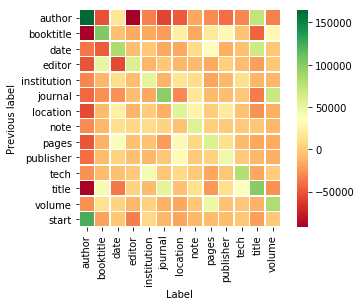

In [27]:
import seaborn as sns
import matplotlib.pylab as plt

num_labels = len(all_citation_labels)
transitions = np.zeros((num_labels + 1, num_labels))

for i, l1 in enumerate(all_citation_labels):
    for j, l2 in enumerate(all_citation_labels):
        transitions[i][j] = w_perceptron.get('transition:' + l1 + "_" + l2) or 0.0
        
for i, l in enumerate(all_citation_labels):
    transitions[num_labels][i] = w_perceptron.get('transition:start_' + l) or 0.0

ax = sns.heatmap(transitions, linewidth=0.5, 
                 xticklabels = all_citation_labels,
                 yticklabels = all_citation_labels + ['start'],
                 square=True,  cmap="RdYlGn")

plt.xlabel("Label")
plt.ylabel("Previous label")
plt.show()

The positive tells us the transitions prefers the label to remain the same (unless, of course, the emissions force a change). There are a few other transitions that also have high scores. For example, the model seems to prefer to start a sequence with the `author` label. The heatmap also shows transitions that the model does not like. It is worth thinking about whether these make sense, and how we can fix them if they do not.

## Exercises

1. Find better hyper-parameters for the structured Perceptron learner via cross-validation. 

2. Design and experiment with more features.

3. Measure how long the inference step above takes, and optimize it for speed. Also, replace dictionary-based implementation of vectors with an efficient one, say, using numpy.

4. Derive the gradient of the structured Perceptron loss with respect to ${\bf w}$ and ${\bf u}$ and show that the updates above are correct.

5. Implement a structured SVM learner. For your implementation, you should use the existing implementation of inference as a sub-routine for loss-augmented inference. 

6. Implement a CRF learner. For the CRF, you will need to compute the expected feature vector given a model. You will have to derive and implement this inference step.

7. Evaluate a higher order Markov model for the task. Implement inference for the higher order Markov model using the existing implementation of the first order inference as a sub-routine.

8. Use a different input representation, say, a neural network for the emission scores. Perhaps also the transition scores.

9. How would you add constraints to help the model learn and predict meaningful outputs? See Chang et al (2007) for ideas.

10. Here, we have taken the original problem of populating fields from text and forced it to look like a sequence labeling problem. It is worth thinking about whether this is the only right way to frame the problem, and indeed, whether this is even a right approach. What do we lose by encoding the information extraction task in this fashion?

11. Is the evaluation at the token level a meaningful metric for this task? How would you change the evaluation?


## References

* Ming-Wei Chang, Lev Ratinov, and Dan Roth. 2007. [Guiding Semi-Supervision with Constraint-Driven Learning](https://www.aclweb.org/anthology/P07-1036.pdf). In Proceedings of the 45th annual meeting of the association of computational linguistics, pages 280–287.

* Michael Collins. 2002. [Discriminative Training Methods for Hidden Markov Models: Theory and Experiments with Perceptron Algorithms](https://www.aclweb.org/anthology/W02-1001.pdf). In Empirical Methods in Natural Language Processing.

* Trond Grenager, Dan Klein, and Christopher D. Manning. 2005. [Unsupervised learning of field segmentation models for information extraction](https://www.aclweb.org/anthology/P05-1046.pdf). In Proceedings of the 43rd Annual Meeting on Association for Computational Linguistics, pages 371–378.

* John Lafferty, Andrew McCallum, and Fernando Pereira. 2001. [Conditional random fields: Probabilistic models for segmenting and labeling sequence data](https://repository.upenn.edu/cgi/viewcontent.cgi?article=1162&context=cis_papers). In International Conference on Machine Learning (ICML), pages 282–289.

* Andrew McCallum, Dayne Freitag, and Fernando Pereira. 2000. [Maximum Entropy Markov Models for Information Extraction and Segmentation](https://pdfs.semanticscholar.org/a13e/bf46f8e200192de40c3677736378e5384140.pdf). In International Conference on Machine Learning (ICML), pages 591–598.
